<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/1IMRxByfg7gjoZ5i7rxvuNDvSrbdOJOc-/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install evaluate

In [5]:
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import transformers
import evaluate
from transformers import AutoModel, AutoConfig
from typing import Union
from datasets import Dataset
import torch.nn.functional as F
from transformers import Trainer, TrainingArguments

sns.set(palette='summer')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
!nvidia-smi

Wed Apr 10 11:29:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Обработка данных

In [51]:
file_path = 'data_problems.xlsx'
df = pd.read_excel(file_path)
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,Задача,Тема
0,Между девятью планетами Солнечной системы введ...,Графы
1,"В стране Цифра есть 9 городов с названиями 1, ...",Графы
2,"В государстве 100 городов, и из каждого из них...",Графы
3,"В классе 30 человек. Может ли быть так, что 9 ...",Графы
4,В городе Маленьком 15 телефонов. Можно ли их с...,Графы


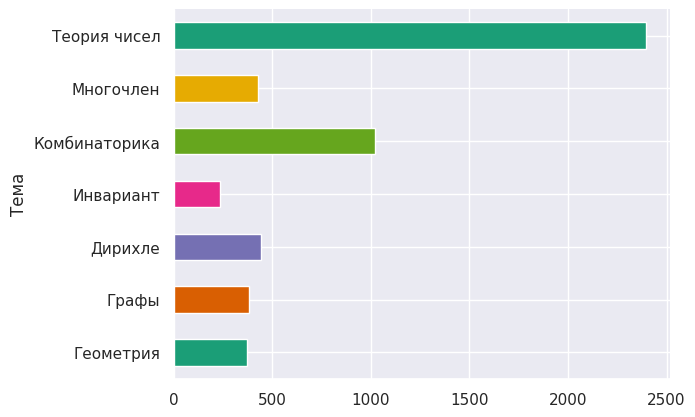

In [8]:
df.groupby('Тема').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [52]:
# почистим от мусора
print((df['Задача'] == ' ').sum())
df = df[df['Задача'] != ' ']
df.reset_index(drop=True, inplace=True)
(df['Задача'] == ' ').sum()

7


0

In [53]:
df = df.loc[df['Задача'].astype(str).apply(lambda x: len(x.strip()) >= 8 and x.strip() != ''), :]

In [ ]:
df.isna().sum().sum()

0

In [54]:
import string
# уберем все знаки препинания
df['Задача'] = df['Задача'].apply(lambda x: x.translate(str.maketrans(string.punctuation,
                                                                        ' '*len(string.punctuation))))

In [55]:
duplicates_with_different_themes = df.groupby('Задача').filter(lambda x: x['Тема'].nunique() > 1)
# Подсчет количества дубликатов
count = duplicates_with_different_themes['Задача'].value_counts().sum()
count

1664

In [56]:
theme_counts = df['Тема'].value_counts()
most_popular_themes_first = theme_counts.index.tolist()
df_sorted_by_popularity = df.sort_values(by='Тема', key=lambda x: x.map(lambda y: most_popular_themes_first.index(y)))
df = df_sorted_by_popularity.drop_duplicates(subset=['Задача'], keep='last')

In [57]:
duplicates_with_different_themes = df.groupby('Задача').filter(lambda x: x['Тема'].nunique() > 1)
# Подсчет количества дубликатов
count = duplicates_with_different_themes['Задача'].value_counts().sum()
count

0

In [ ]:
dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['Задача', 'Тема', '__index_level_0__'],
    num_rows: 4322
})

In [ ]:
dataset = dataset.train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['Задача', 'Тема', '__index_level_0__'],
        num_rows: 3457
    })
    test: Dataset({
        features: ['Задача', 'Тема', '__index_level_0__'],
        num_rows: 865
    })
})

In [ ]:
tokenizer_1 = transformers.AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

In [ ]:
def preprocess_function_1(examples):
    model_inputs = tokenizer_1(examples["Задача"], padding="max_length", max_length=128, truncation=True)
    label_to_id = {"Теория чисел": 0, "Комбинаторика": 1, "Многочлен": 2, "Инвариант": 3,
                   "Дирихле": 4, "Графы": 5, "Геометрия": 6}
    labels = [label_to_id[theme] for theme in examples["Тема"]]
    model_inputs["labels"] = labels
    return model_inputs

In [ ]:
tokenized_dataset_1 = dataset.map(preprocess_function_1, batched=True)

Map:   0%|          | 0/3457 [00:00<?, ? examples/s]

Map:   0%|          | 0/865 [00:00<?, ? examples/s]

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [15]:
class TransformerClassificationModel(nn.Module):
    def __init__(self,
                 base_transformer_model: Union[str, nn.Module],
                 num_labels: int=7,
                 dropout_rate: float=0.1,
                 class_weights=None,
                 ):
        super(TransformerClassificationModel, self).__init__()

        if isinstance(base_transformer_model, str):
            config = AutoConfig.from_pretrained(base_transformer_model, output_attentions=True)
            self.backbone = AutoModel.from_pretrained(base_transformer_model, config=config)
        else:
            self.backbone = base_transformer_model

        hidden_size = self.backbone.config.hidden_size
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.num_labels = num_labels
        self.dropout = nn.Dropout(dropout_rate)

        if class_weights is not None:
            self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, labels=None, return_attentions=False):
        output = self.backbone(input_ids=input_ids, attention_mask=attention_mask)

        # Прогоняем [CLS] через еще один слой с активацией tanh
        pooled_output = self.dropout(output.pooler_output)
        logits = self.classifier(pooled_output)
        outputs = {'logits': logits}

        if labels is not None:
            # взвешенная CE для более эффективной борьбы с дисбалансом классов
            loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            #loss = F.cross_entropy(logits.view(-1, self.num_labels), labels.view(-1))
            outputs['loss'] = loss

        if return_attentions:
            outputs['attentions'] = output.attentions

        return outputs

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [16]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for name, param in model.backbone.named_parameters():
        param.requires_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [17]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")

    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"],
    }

In [18]:
from sklearn.utils.class_weight import compute_class_weight
# посчитаем количество экземляров классов для вычисления весов для weighted CrossEntropy
data_labels = df.iloc[:, 1].values
npu = np.array(['Теория чисел','Комбинаторика','Многочлен',
                'Инвариант','Дирихле','Графы','Геометрия'], dtype=object)
class_weights = compute_class_weight(class_weight='balanced', classes=npu, y=data_labels)
weights = torch.tensor(class_weights, dtype=torch.float)
weights

tensor([0.3139, 1.0682, 1.5283, 2.6386, 1.5832, 1.6291, 1.6687])

In [19]:
import copy

def train_transformer(transformer_model,
                      tokenized_dataset,
                      freeze_backbone=True,
                      num_epoch: int=10,
                      lr: float=5e-5,
                      batch_size: int=4,
                      warmup_steps: int=500):
    model = copy.deepcopy(transformer_model)

    if freeze_backbone:
        model = freeze_backbone_function(model)

    training_args = TrainingArguments(
        output_dir='./results',
        logging_strategy="epoch",
        logging_dir="./logs",
        num_train_epochs=num_epoch,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=warmup_steps,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer.model, trainer.state.log_history

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [ ]:
rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", dropout_rate=0.2, class_weights=weights)
rubert_tiny_finetuned_with_freezed_backbone, logs_1 = train_transformer(rubert_tiny_transformer_model,
                                                                tokenized_dataset_1,
                                                                freeze_backbone=True,
                                                                num_epoch=7,
                                                                lr=9e-4,
                                                                batch_size=8,
                                                                warmup_steps=400)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.702300,1.491505,0.561850,0.493510,0.460967,0.437034
2,1.396400,1.346920,0.581503,0.507742,0.541725,0.511881
3,1.299300,1.285200,0.572254,0.497687,0.532740,0.502437
4,1.242800,1.249977,0.590751,0.514455,0.539827,0.520007
5,1.209100,1.225823,0.588439,0.515213,0.554752,0.526448
6,1.188900,1.214379,0.584971,0.514638,0.552424,0.525916
7,1.194600,1.210628,0.589595,0.519940,0.558668,0.531222


Checkpoint destination directory ./results/checkpoint-865 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1730 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2595 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3460 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4325 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-5190 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-6055 already exists and is non-empty. Saving will proceed but saved res

In [ ]:
rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", dropout_rate=0.35, class_weights=weights)
rubert_tiny_full_finetuned, logs_2 = train_transformer(rubert_tiny_transformer_model,
                                               tokenized_dataset_1,
                                               freeze_backbone=False,
                                               num_epoch=7,
                                               lr=3e-5,
                                               batch_size=9,
                                               warmup_steps=450)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.547200,1.175390,0.639306,0.615397,0.577124,0.577534
2,0.990100,0.975573,0.690173,0.643202,0.662432,0.648197
3,0.755100,0.951123,0.713295,0.690916,0.683740,0.683952
4,0.622100,0.945996,0.730636,0.693761,0.713954,0.700860
5,0.516600,1.004741,0.735260,0.700091,0.716806,0.707203
6,0.448300,1.055064,0.738728,0.705851,0.727207,0.714906
7,0.400400,1.098118,0.735260,0.703065,0.711243,0.706374


Checkpoint destination directory ./results/checkpoint-865 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1730 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2595 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3460 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4325 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-5190 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-6055 already exists and is non-empty. Saving will proceed but saved res

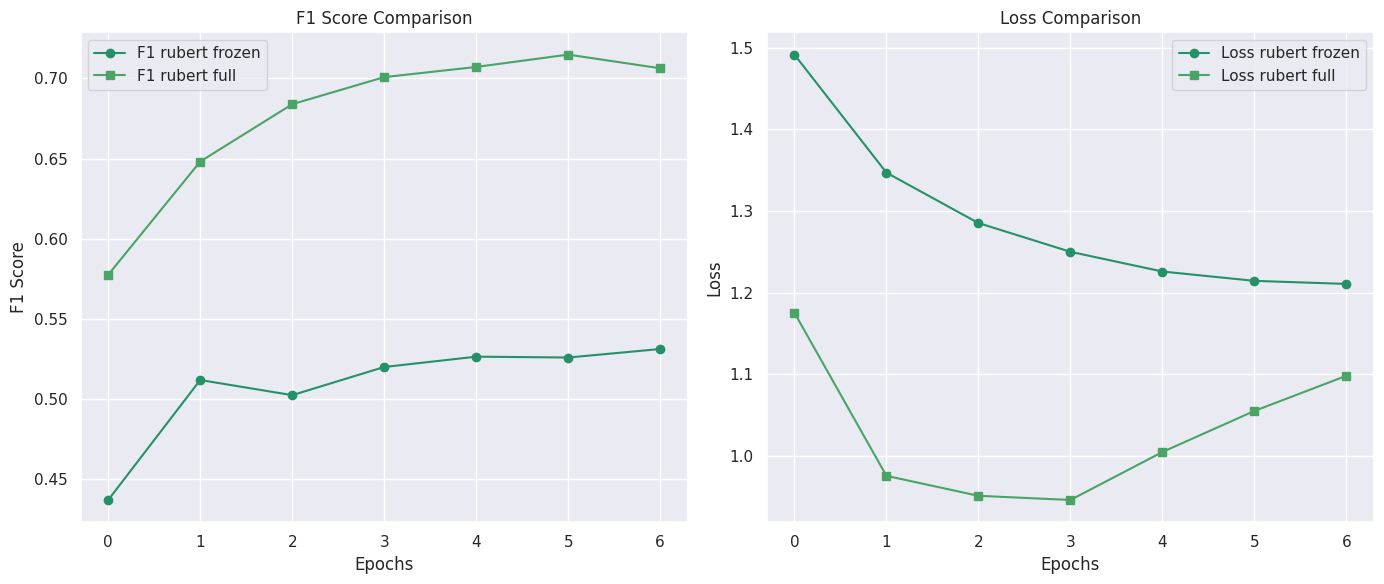

In [ ]:
eval_f1_history_1 = []
eval_loss_history_1 = []
eval_f1_history_2 = []
eval_loss_history_2 = []

for log in logs_1:
    if 'eval_loss' in log:
        eval_loss_history_1.append(log['eval_loss'])
    if 'eval_f1' in log:
        eval_f1_history_1.append(log['eval_f1'])

for log in logs_2:
    if 'eval_loss' in log:
        eval_loss_history_2.append(log['eval_loss'])
    if 'eval_f1' in log:
        eval_f1_history_2.append(log['eval_f1'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(eval_f1_history_1, label='F1 rubert frozen', marker='o')
plt.plot(eval_f1_history_2, label='F1 rubert full', marker='s')
plt.title('F1 Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_loss_history_1, label='Loss rubert frozen', marker='o')
plt.plot(eval_loss_history_2, label='Loss rubert full', marker='s')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

# Поскольку MathBert токенизирует русские слова по символам, карты внимания становятся неинтерпретируемы, поэтому переведем задачи на английский язык

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

model_name = 'Helsinki-NLP/opus-mt-ru-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)


def translate_with_transformers(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    with torch.no_grad():
        translated_ids = model.generate(**inputs)

    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    return translated_text

In [ ]:
tqdm.pandas()

df['Задача'] = df['Задача'].progress_apply(translate_with_transformers)
df['Тема'] = df['Тема'].progress_apply(translate_with_transformers)

  0%|          | 0/5266 [00:00<?, ?it/s]

  0%|          | 0/5266 [00:00<?, ?it/s]

In [ ]:
# сохраним полученный файл с переводами для дальнейшего использования
df.to_excel('/content/data_prb.xlsx', index=False, engine='openpyxl')

In [ ]:
from google.colab import files
files.download('/content/data_prb.xlsx')

In [61]:
file_path = 'data_prb.xlsx'
df = pd.read_excel(file_path)
df.head()

,Задача,Тема
0,"Between the nine planets of the solar system, ...",Counts
1,"In the country of Cifra, there are nine cities...",Counts
2,There are four roads in and out of 100 cities....,Counts
3,30 people in class can be so 9 of them have 3 ...,Counts
4,"In the town of Little 15 phones, can they be w...",Counts


In [62]:
# еще почистим
df = df.loc[df['Задача'].astype(str).apply(lambda x: len(x.strip()) >= 8 and x.strip() != ''), :]

In [63]:
theme_counts = df['Тема'].value_counts()
most_popular_themes_first = theme_counts.index.tolist()
df_sorted_by_popularity = df.sort_values(by='Тема', key=lambda x: x.map(lambda y: most_popular_themes_first.index(y)))
df = df_sorted_by_popularity.drop_duplicates(subset=['Задача'], keep='last')

In [64]:
tokenizer_2 = transformers.AutoTokenizer.from_pretrained("tbs17/MathBert")

In [65]:
def preprocess_function_2(examples):
    model_inputs = tokenizer_2(examples["Задача"], padding="max_length", max_length=128, truncation=True)
    label_to_id = {"Number theory": 0, "Combinatories": 1, "Multi-member": 2, "Invariant": 3,
                   "Dirichle": 4, "Counts": 5, "Geometry": 6}
    labels = [label_to_id[theme] for theme in examples["Тема"]]
    model_inputs["labels"] = labels
    return model_inputs

In [25]:
dataset_2 = Dataset.from_pandas(df)
dataset_2 = dataset_2.train_test_split(test_size=0.2)
tokenized_dataset_2 = dataset_2.map(preprocess_function_2, batched=True)
tokenized_dataset_2

Map:   0%|          | 0/3429 [00:00<?, ? examples/s]

Map:   0%|          | 0/858 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Задача', 'Тема', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3429
    })
    test: Dataset({
        features: ['Задача', 'Тема', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 858
    })
})

In [34]:
MathBert_transformer_model = TransformerClassificationModel("tbs17/MathBert", dropout_rate=0.15, class_weights=weights)
MathBert_finetuned_with_freezed_backbone, logs_4 = train_transformer(MathBert_transformer_model,
                                               tokenized_dataset_2,
                                               freeze_backbone=True,
                                               num_epoch=7,
                                               lr=5e-4,
                                               batch_size=16,
                                               warmup_steps=350)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.794900,1.633776,0.432401,0.377165,0.419584,0.277551
2,1.494900,1.516708,0.526807,0.353011,0.420433,0.356402
3,1.392000,1.395196,0.515152,0.392385,0.473468,0.417095
4,1.347600,1.338915,0.554779,0.465752,0.487956,0.449575
5,1.304700,1.319743,0.516317,0.434595,0.501187,0.452559
6,1.275000,1.319537,0.544289,0.456224,0.491540,0.447152
7,1.269700,1.299937,0.545455,0.456106,0.520795,0.477594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Checkpoint destination directory ./results/checkpoint-858 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Checkpoint destination directory ./results/checkpoint-1716 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

In [32]:
MathBert_transformer_model = TransformerClassificationModel("tbs17/MathBert", dropout_rate=0.3, class_weights=weights)
MathBert_full_finetuned, logs_3 = train_transformer(MathBert_transformer_model,
                                               tokenized_dataset_2,
                                               freeze_backbone=False,
                                               num_epoch=7,
                                               lr=0.2e-5,
                                               batch_size=32,
                                               warmup_steps=400)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.772300,1.440798,0.479021,0.330620,0.447755,0.343189
2,1.283200,1.240920,0.554779,0.421797,0.475395,0.427976
3,1.126100,1.172916,0.617716,0.550112,0.542933,0.527953
4,1.017300,1.087492,0.631702,0.575456,0.592727,0.582707
5,0.933000,1.079603,0.648019,0.591133,0.605986,0.596690
6,0.881600,1.059804,0.646853,0.586460,0.615350,0.597658
7,0.869500,1.052815,0.646853,0.590808,0.622493,0.604133


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Checkpoint destination directory ./results/checkpoint-858 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1716 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2574 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3432 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-4290 already exists and is non-empty. Saving will proceed but sa

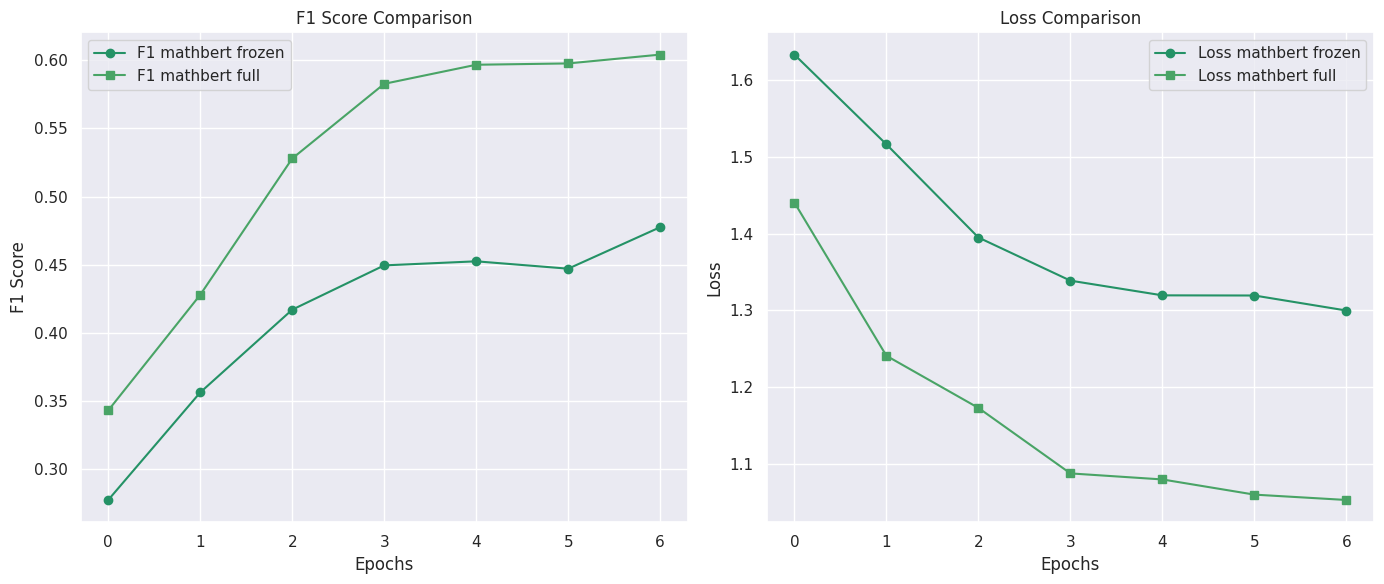

In [35]:
eval_f1_history_1 = []
eval_loss_history_1 = []
eval_f1_history_2 = []
eval_loss_history_2 = []

for log in logs_4:
    if 'eval_loss' in log:
        eval_loss_history_1.append(log['eval_loss'])
    if 'eval_f1' in log:
        eval_f1_history_1.append(log['eval_f1'])

for log in logs_3:
    if 'eval_loss' in log:
        eval_loss_history_2.append(log['eval_loss'])
    if 'eval_f1' in log:
        eval_f1_history_2.append(log['eval_f1'])

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(eval_f1_history_1, label='F1 mathbert frozen', marker='o')
plt.plot(eval_f1_history_2, label='F1 mathbert full', marker='s')
plt.title('F1 Score Comparison')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_loss_history_1, label='Loss mathbert frozen', marker='o')
plt.plot(eval_loss_history_2, label='Loss mathbert full', marker='s')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

MathBert показал себя хуже,чем rubert. Скорее всего лучшим препроцессингом можно получить качетво намного лучше, как минимум, качетсво перевода

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [36]:
def draw_first_layer_attention_maps(attention_head_ids, text: str,
                                    model: TransformerClassificationModel,
                                    mode: str, f_size: int,
                                    token_names=True):

    if mode == "rubert":
        inputs = tokenizer_1(text, return_tensors="pt")
    else:
        inputs = tokenizer_2(text, return_tensors="pt")

    input_ids = inputs["input_ids"].to(device)

    if mode == "rubert":
        tokens = [tokenizer_1.decode(token_id) for token_id in input_ids[0]]
    else:
        tokens = [tokenizer_2.decode(token_id) for token_id in input_ids[0]]

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, return_attentions=True)
    attentions = outputs['attentions'][0]

    num_heads = len(attention_head_ids)
    fig, axes = plt.subplots(1, num_heads, figsize=(num_heads * f_size, f_size))

    for i, head_id in enumerate(attention_head_ids):
        attention_map = attentions[0, head_id].cpu().detach().numpy()

        if num_heads == 1:
            ax = axes
        else:
            ax = axes[i]

        if token_names:
            sns.heatmap(attention_map, cmap='viridis', ax=ax, xticklabels=tokens, yticklabels=tokens)
        else:
            sns.heatmap(attention_map, cmap='viridis', ax=ax)
        ax.set_title(f"Head {head_id}")
        ax.set_xlabel("Tokens")
        ax.set_ylabel("Tokens")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=6)
        plt.setp(ax.get_yticklabels(), fontsize=6)

    plt.tight_layout()
    plt.show()

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

# Rubert до дообучения

In [58]:
rubert_tiny = TransformerClassificationModel("cointegrated/rubert-tiny2", class_weights=weights).to(device)

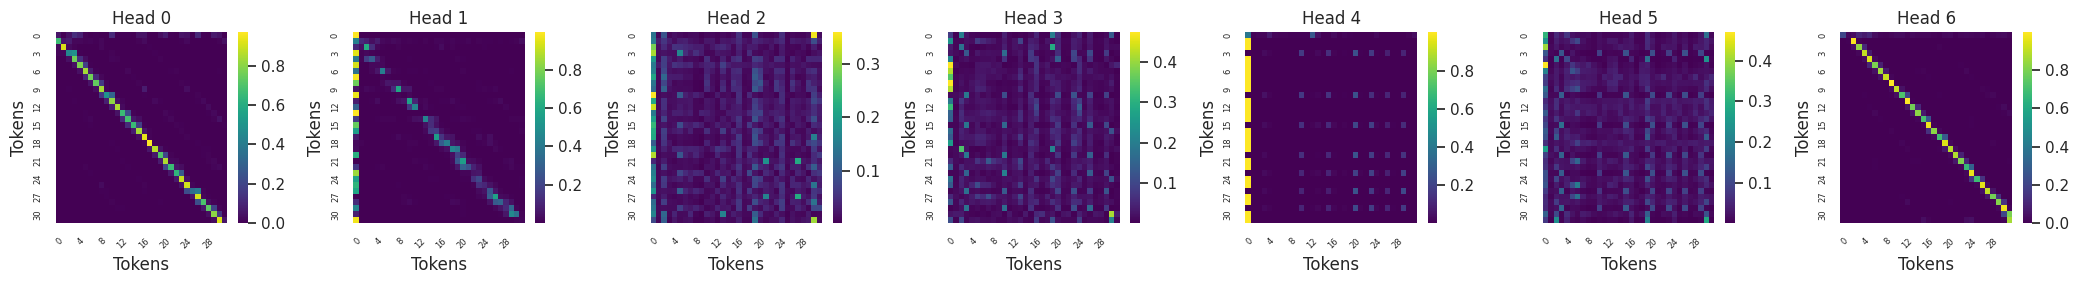

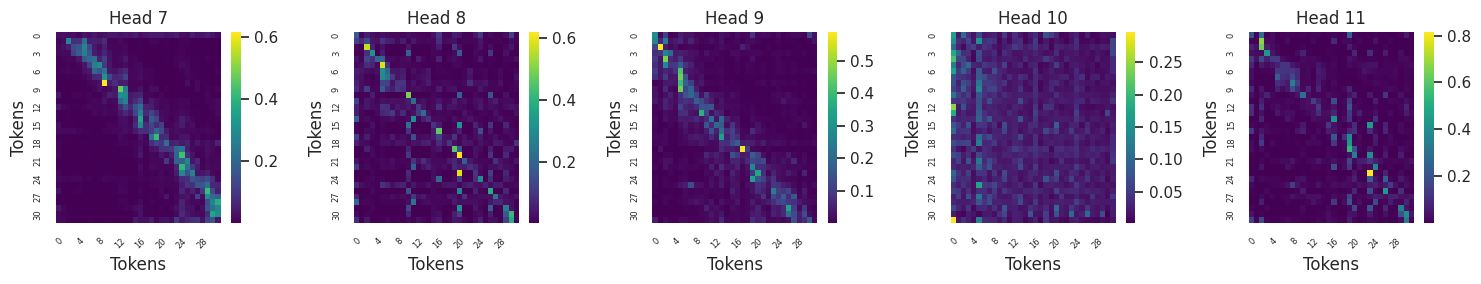

In [59]:
draw_first_layer_attention_maps([0,1,2,3,4,5,6],
                                df["Задача"][3],
                                rubert_tiny,
                                "rubert",
                                3,
                                token_names=False)
draw_first_layer_attention_maps([7,8,9,10,11],
                                df["Задача"][3],
                                rubert_tiny,
                                "rubert",
                                3,
                                token_names=False)

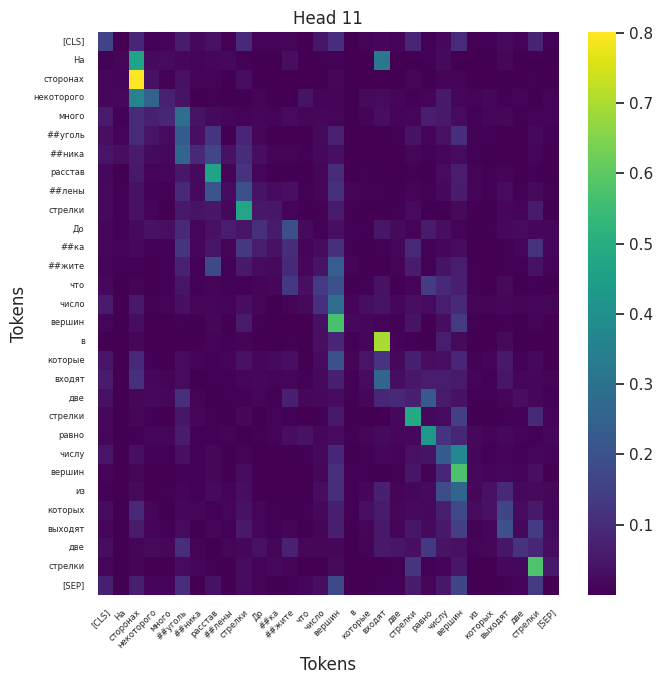

In [60]:
draw_first_layer_attention_maps([11],
                                df["Задача"][30],
                                rubert_tiny,
                                "rubert",
                                7,
                                token_names=True)

In [66]:
mathbert = TransformerClassificationModel("tbs17/MathBert", class_weights=weights).to(device)

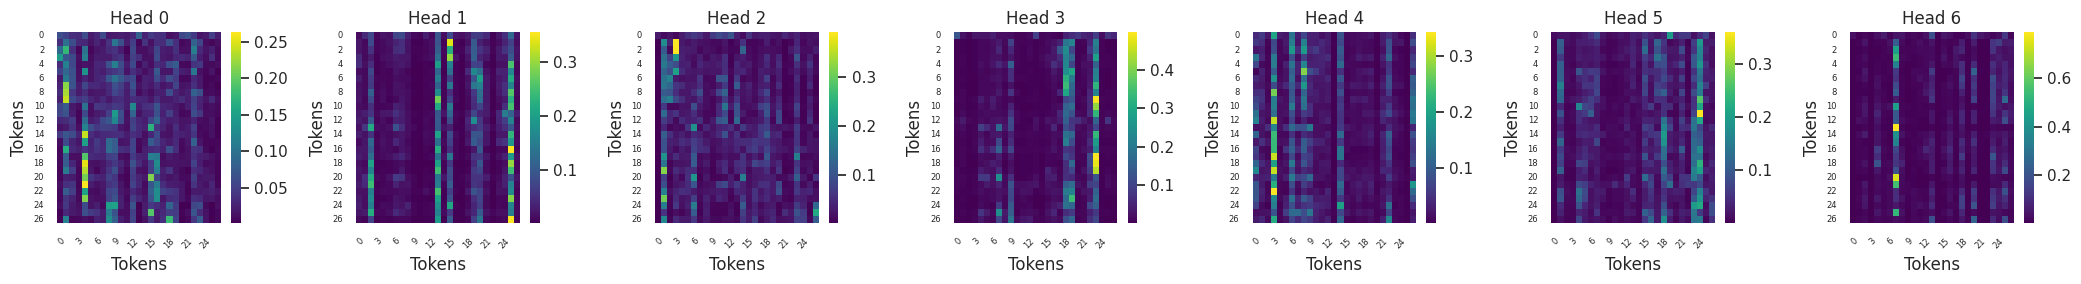

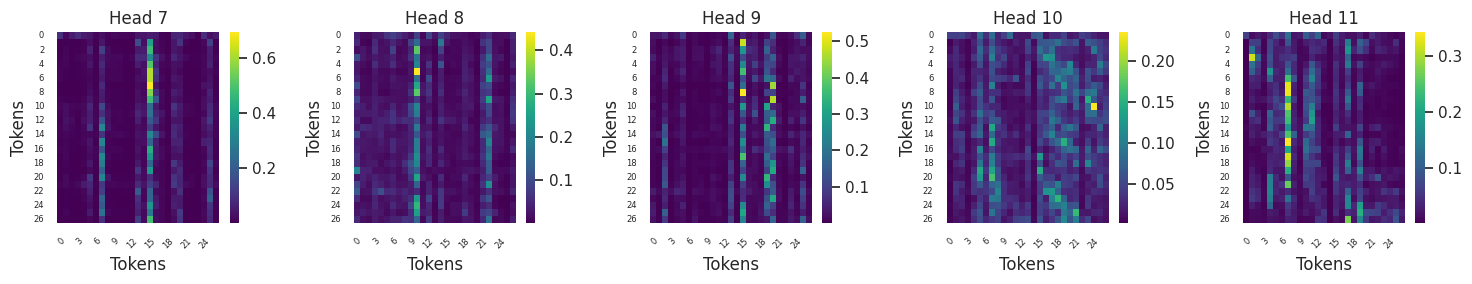

In [67]:
draw_first_layer_attention_maps([0,1,2,3,4,5,6],
                                df["Задача"][3],
                                mathbert,
                                "rubert",
                                3,
                                token_names=False)
draw_first_layer_attention_maps([7,8,9,10,11],
                                df["Задача"][3],
                                mathbert,
                                "rubert",
                                3,
                                token_names=False)

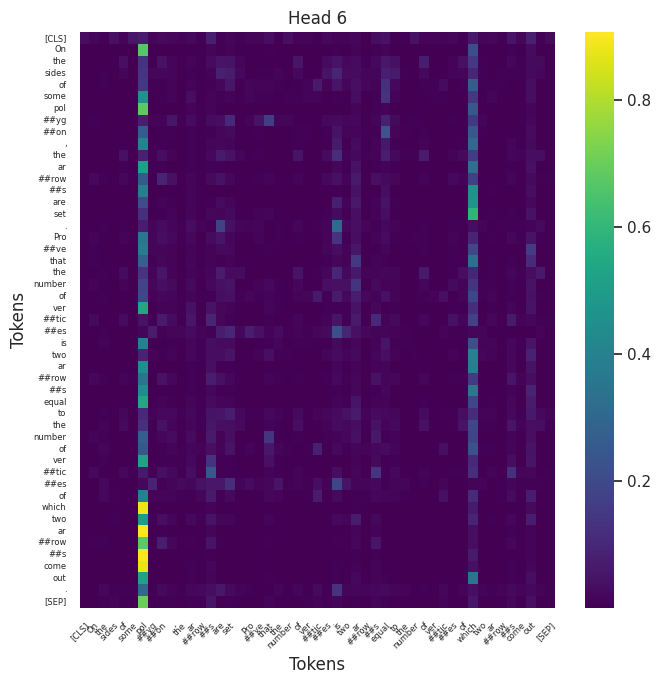

In [68]:
draw_first_layer_attention_maps([6],
                                df["Задача"][30],
                                mathbert,
                                "rubert",
                                7,
                                token_names=True)

Карты внимания не имеют значительных отличий от дообученных, скорее всего это вызвано небольшим размером датасета
А так же есть зависимость от предназначения моделей

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

# Rubert'ы

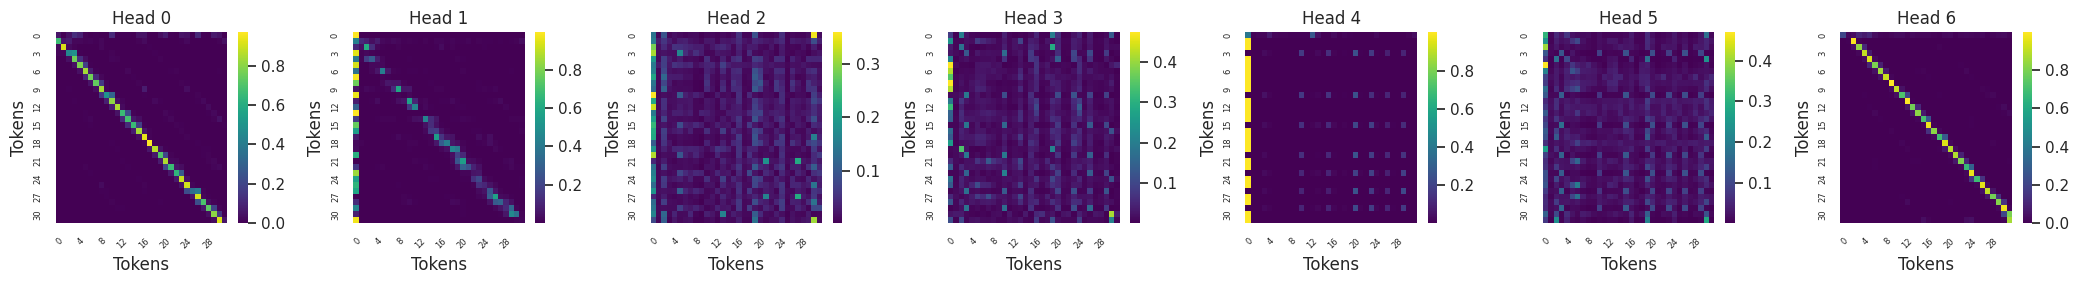

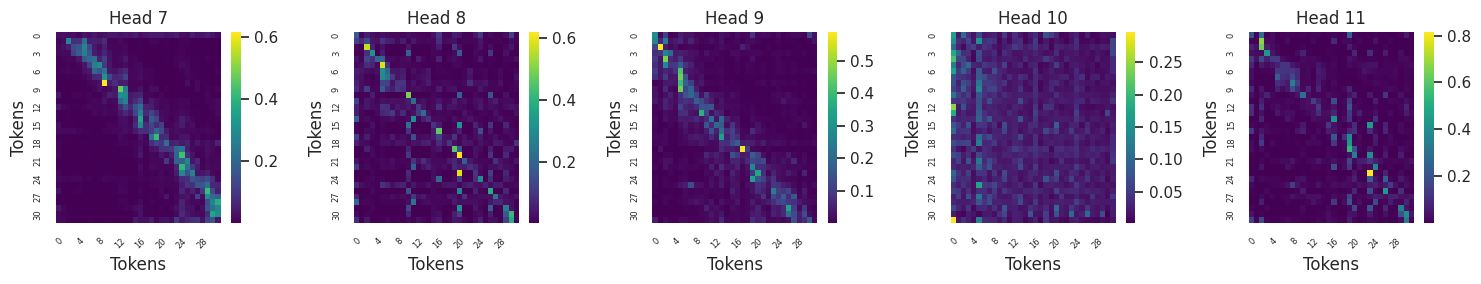

In [ ]:
draw_first_layer_attention_maps([0,1,2,3,4,5,6],
                                df["Задача"][3],
                                rubert_tiny_finetuned_with_freezed_backbone,
                                "rubert",
                                3,
                                token_names=False)
draw_first_layer_attention_maps([7,8,9,10,11],
                                df["Задача"][3],
                                rubert_tiny_finetuned_with_freezed_backbone,
                                "rubert",
                                3,
                                token_names=False)

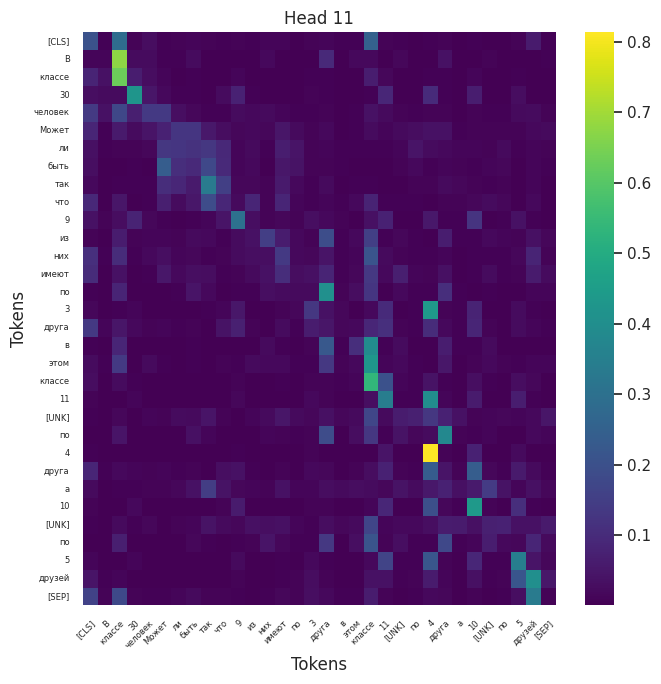

In [ ]:
draw_first_layer_attention_maps([11],
                                df["Задача"][3],
                                rubert_tiny_finetuned_with_freezed_backbone,
                                "rubert",
                                7,
                                token_names=True)

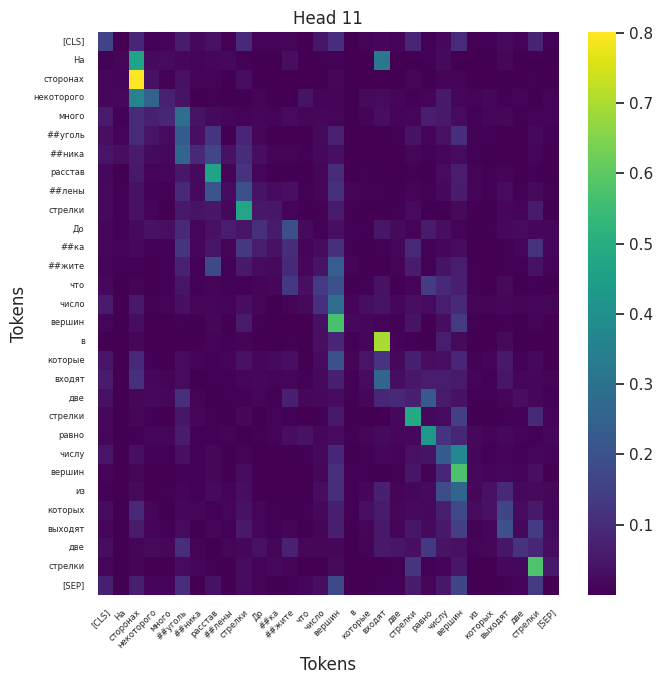

In [ ]:
draw_first_layer_attention_maps([11],
                                df["Задача"][30],
                                rubert_tiny_finetuned_with_freezed_backbone,
                                "rubert",
                                7,
                                token_names=True)

Хорошо прослеживаются связи между числами,а так же различными геометрическими терминами, особенное внимание уделено вершинам,но все-таки качество карт далеко не на высоком уровне

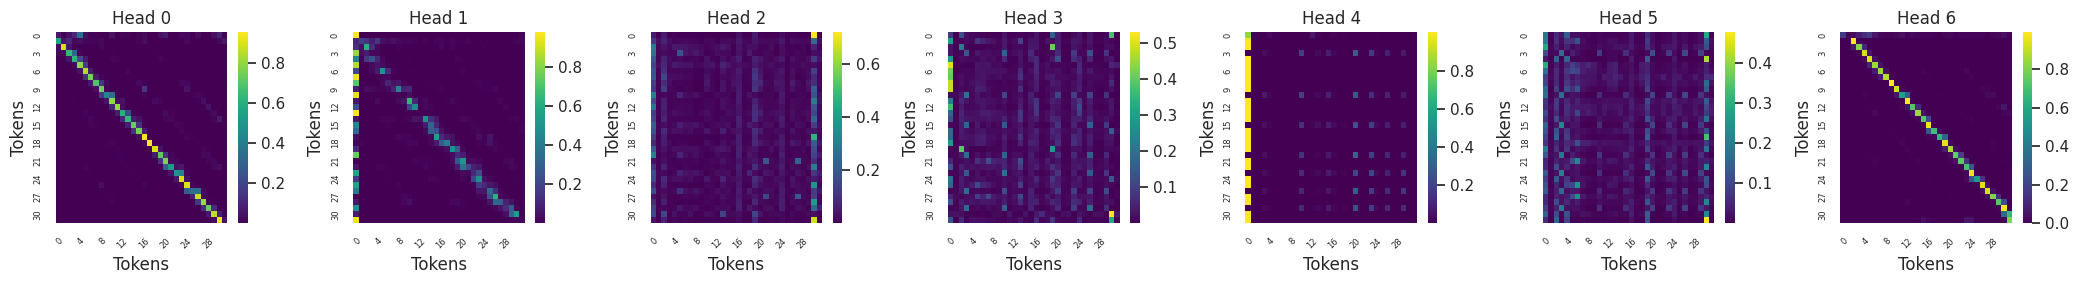

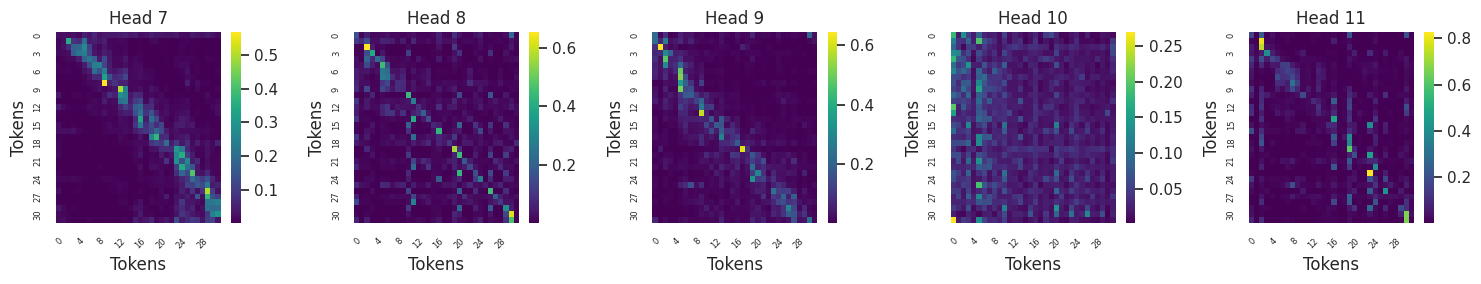

In [ ]:
draw_first_layer_attention_maps([0,1,2,3,4,5,6],
                                df["Задача"][3],
                                rubert_tiny_full_finetuned,
                                "rubert",
                                3,
                                token_names=False)
draw_first_layer_attention_maps([7,8,9,10,11],
                                df["Задача"][3],
                                rubert_tiny_full_finetuned,
                                "rubert",
                                3,
                                token_names=False)

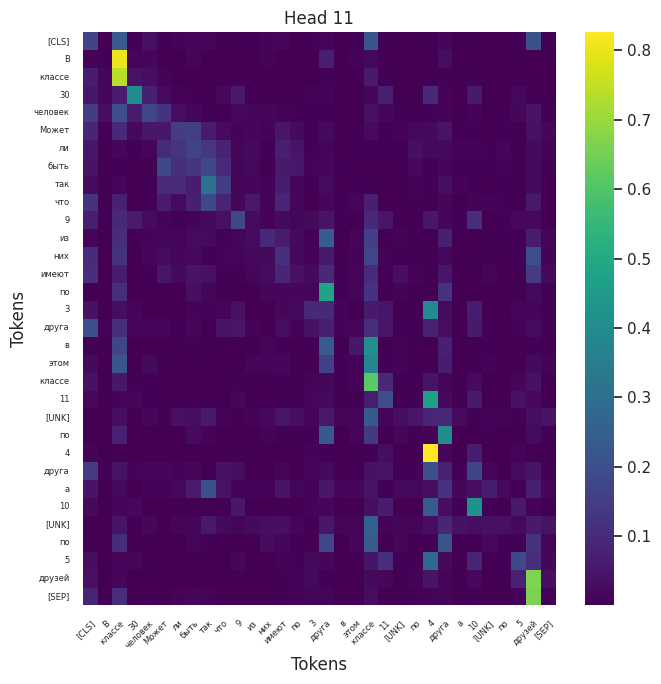

In [ ]:
draw_first_layer_attention_maps([11],
                                df["Задача"][3],
                                rubert_tiny_full_finetuned,
                                "rubert",
                                7,
                                token_names=True)

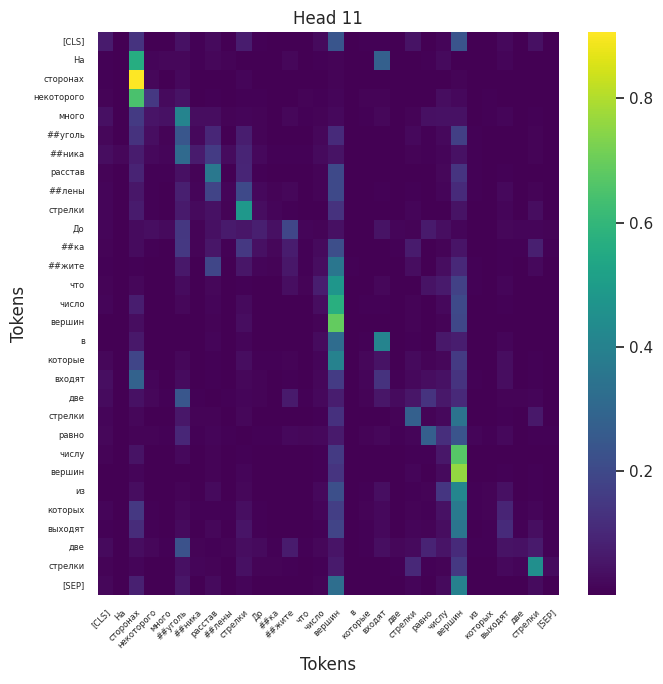

In [ ]:
draw_first_layer_attention_maps([11],
                                df["Задача"][30],
                                rubert_tiny_full_finetuned,
                                "rubert",
                                7,
                                token_names=True)

Связи прослеживаются практически аналогично модели с замароженным backbone'ом, хотя качество данной модели, значительно лучше

# MathBert'ы

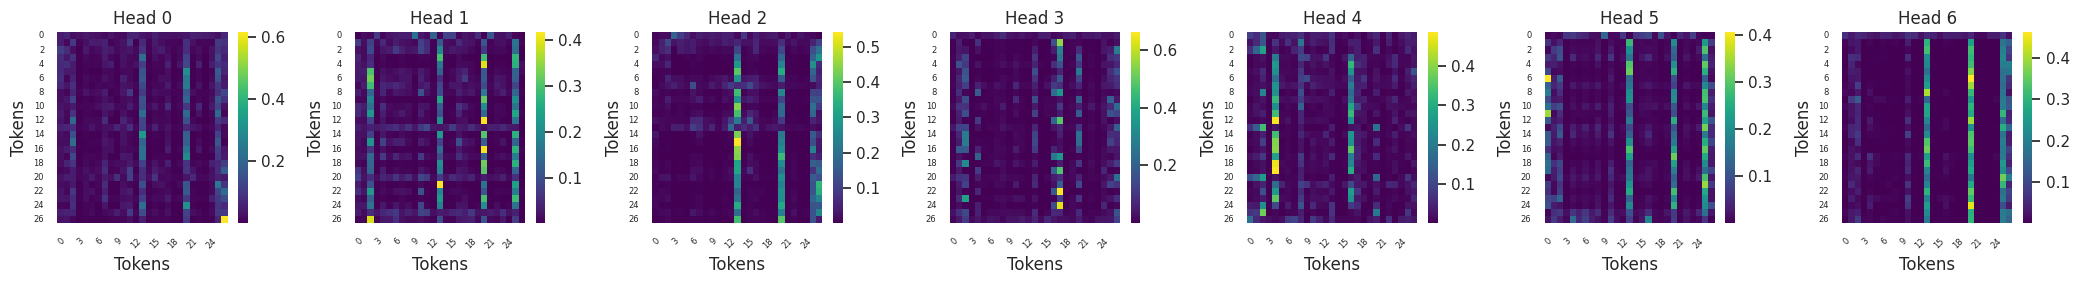

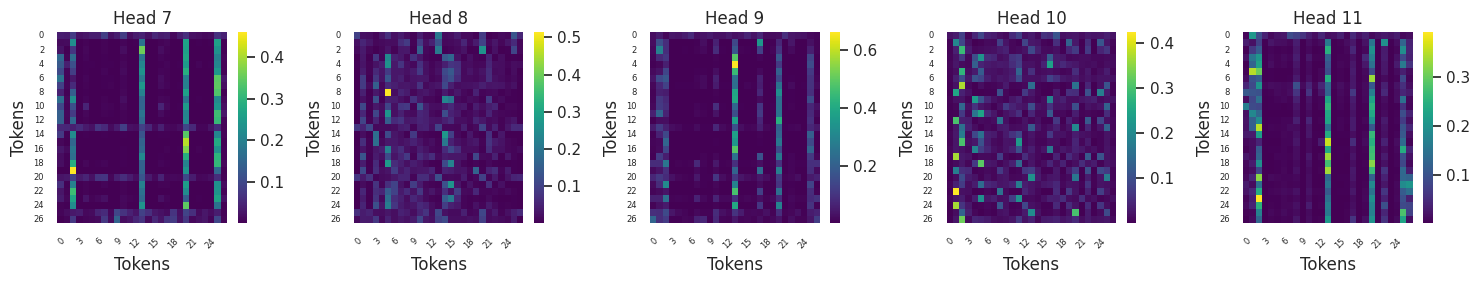

In [38]:
draw_first_layer_attention_maps([0,1,2,3,4,5,6],
                                df["Задача"][3],
                                MathBert_finetuned_with_freezed_backbone,
                                "bert",
                                3,
                                token_names=False)
draw_first_layer_attention_maps([7,8,9,10,11],
                                df["Задача"][3],
                                MathBert_finetuned_with_freezed_backbone,
                                "bert",
                                3,
                                token_names=False)

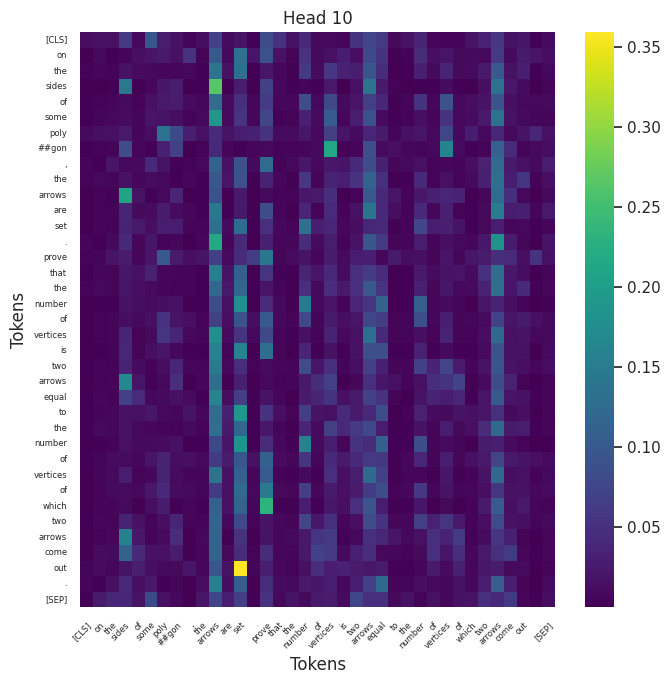

In [40]:
draw_first_layer_attention_maps([10],
                                df["Задача"][30],
                                MathBert_finetuned_with_freezed_backbone,
                                "bert",
                                7,
                                token_names=True)

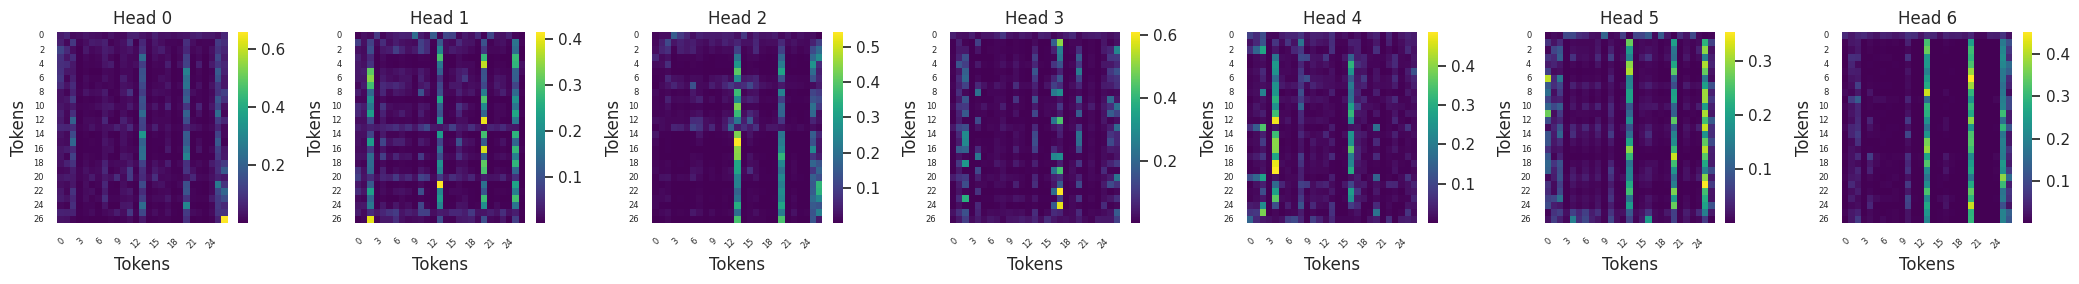

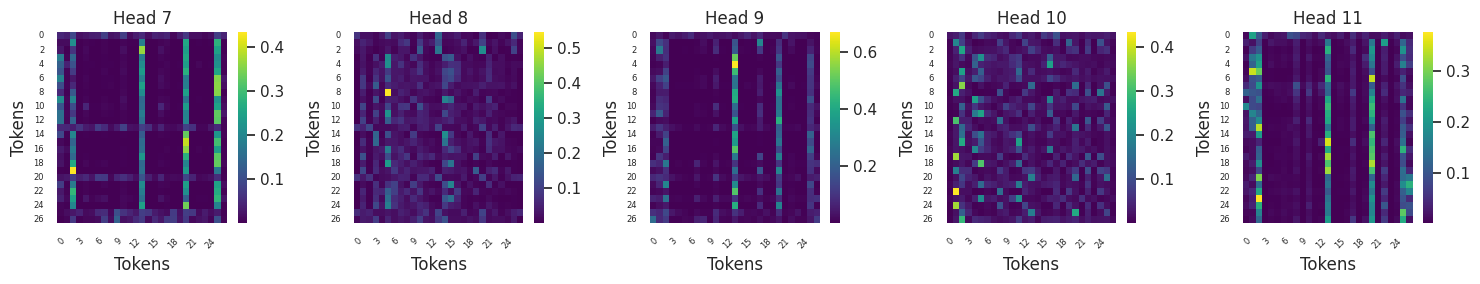

In [41]:
draw_first_layer_attention_maps([0,1,2,3,4,5,6],
                                df["Задача"][3],
                                MathBert_full_finetuned,
                                "bert",
                                3,
                                token_names=False)
draw_first_layer_attention_maps([7,8,9,10,11],
                                df["Задача"][3],
                                MathBert_full_finetuned,
                                "bert",
                                3,
                                token_names=False)

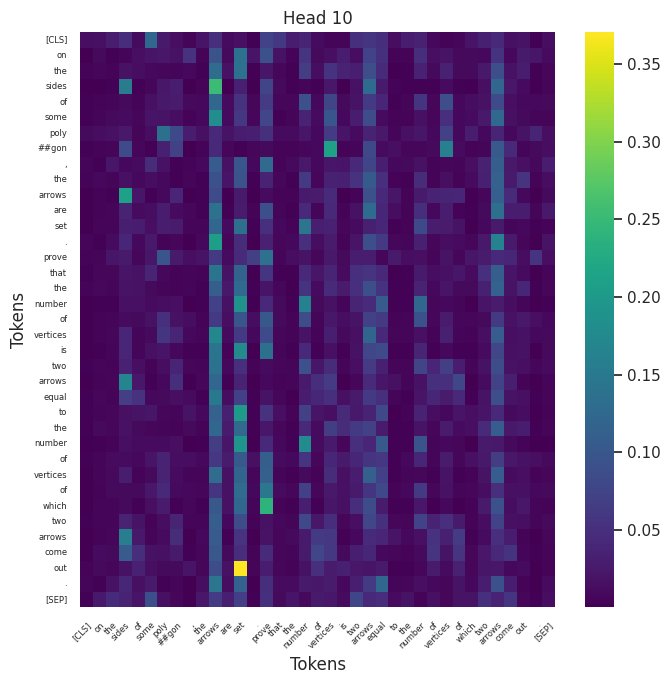

In [42]:
draw_first_layer_attention_maps([10],
                                df["Задача"][30],
                                MathBert_full_finetuned,
                                "bert",
                                7,
                                token_names=True)

Качетво карт внимания у MathBert опять же явно хуже,они практически неинтерпретируемы